# Modeling - Simple Model with Augmented Input

In [12]:
# import necessary packages
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pickle

In [2]:
def load_az_dataset(datasetPath):
    # initialize the list of data and labels
    data = []
    labels = []
    # loop over the rows of the A-Z handwritten digit dataset
    for row in open(datasetPath):
        # parse the label and image from the row
        row = row.split(",")
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]], dtype="uint8")
        # images are represented as single channel (grayscale) images
        # that are 28x28=784 pixels -- we need to take this flattened
        # 784-d list of numbers and repshape them into a 28x28 matrix
        image = image.reshape((28, 28, 1))
        # update the list of data and labels
        data.append(image)
        labels.append(label)
    # convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")
    # bring values between 0 and 1
    data /= 255.0
    # return a 2-tuple of the A-Z data and labels
    return (data, labels)

In [3]:
# retreive data and labels using our function defined above
data, labels = load_az_dataset('data/NIST_SD19/A_Z Handwritten Data/A_Z Handwritten Data.csv')

In [4]:
# define labels
alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in alpha]

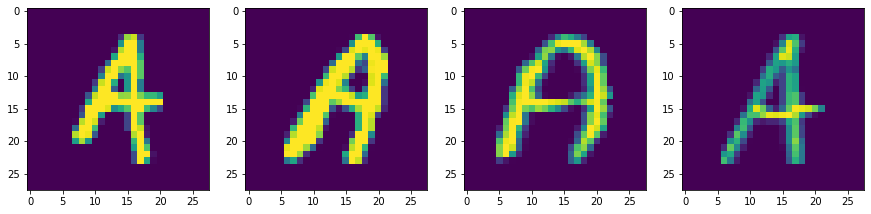

In [5]:
# plot first four images in data
fig, axs = plt.subplots(1, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(4):
    axs[i].imshow(data[i])

In [6]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)

In [7]:
# split data and labels into train, test, validation
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2,
                                                    random_state=42)

In [8]:
# construct the image generator for data augmentation
aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest")

In [9]:
# define model and retrieve a summary
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(len(labelNames), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 26)                3354      
                                                                 
Total params: 103,834
Trainable params: 103,834
Non-trainable params: 0
_________________________________________________________________


In [10]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# train model and produce history artifact
history = model.fit(aug.flow(X_train, y_train, batch_size=128), validation_data=(X_val, y_val), epochs=50)

Epoch 1/50
1863/1863 [==============================] - 43s 22ms/step - loss: 0.7762 - accuracy: 0.7878 - val_loss: 0.2685 - val_accuracy: 0.9316
Epoch 2/50
1863/1863 [==============================] - 43s 23ms/step - loss: 0.3468 - accuracy: 0.9045 - val_loss: 0.1938 - val_accuracy: 0.9492
Epoch 3/50
1863/1863 [==============================] - 42s 23ms/step - loss: 0.2708 - accuracy: 0.9241 - val_loss: 0.1655 - val_accuracy: 0.9545
Epoch 4/50
1863/1863 [==============================] - 42s 22ms/step - loss: 0.2365 - accuracy: 0.9338 - val_loss: 0.1499 - val_accuracy: 0.9592
Epoch 5/50
1863/1863 [==============================] - 42s 23ms/step - loss: 0.2149 - accuracy: 0.9400 - val_loss: 0.1377 - val_accuracy: 0.9624
Epoch 6/50
1863/1863 [==============================] - 42s 22ms/step - loss: 0.2016 - accuracy: 0.9434 - val_loss: 0.1284 - val_accuracy: 0.9652
Epoch 7/50
1863/1863 [==============================] - 42s 22ms/step - loss: 0.1907 - accuracy: 0.9469 - val_loss: 0.1286 -

In [13]:
# save model
model.save('model/Basic_AugInput.h5')

In [14]:
# save model history
with open('hist/Basic_AugInput.hist', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

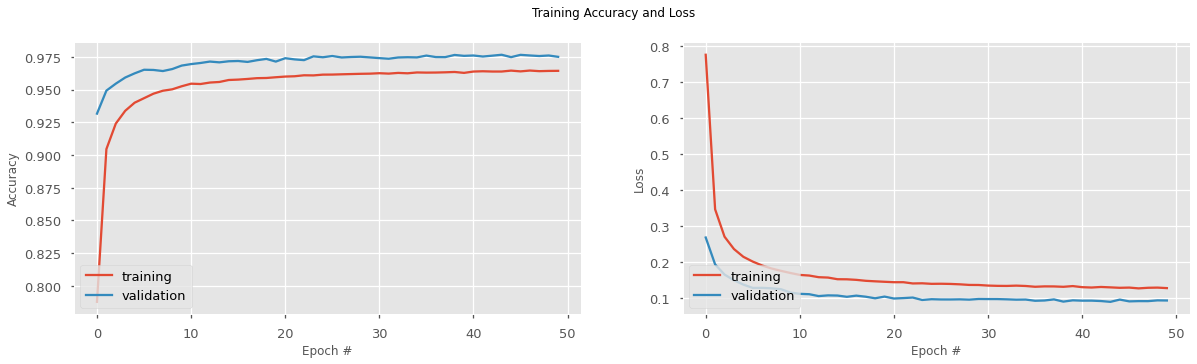

In [24]:
# show plots of both accuracy and loss vs training epochs
N = np.arange(0, 50)
plt.style.use('ggplot')

fig, ax = plt.subplots(1, 2)

fig.suptitle('Training Accuracy and Loss')
fig.set_figheight(5)
fig.set_figwidth(20)

ax[0].plot(N, history.history["accuracy"], label="training")
ax[0].plot(N, history.history["val_accuracy"], label="validation")
ax[0].set(xlabel='Epoch #', ylabel='Accuracy')
ax[0].legend(loc="lower left")

ax[1].plot(N, history.history["loss"], label="training")
ax[1].plot(N, history.history["val_loss"], label="validation")
ax[1].set(xlabel='Epoch #', ylabel='Loss')
ax[1].legend(loc="lower left")

In [25]:
# save the above figure
fig.savefig('hist/Basic_AugInput.pdf', bbox_inches='tight')

In [26]:
# produce predictions on test set and display classification report
predictions = model.predict(X_test[:3000])
print(classification_report(y_test[:3000].argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

              precision    recall  f1-score   support

           A       0.97      1.00      0.98        92
           B       0.98      0.98      0.98        64
           C       0.98      0.98      0.98       201
           D       0.91      0.87      0.89        67
           E       1.00      0.96      0.98        78
           F       1.00      1.00      1.00         8
           G       0.93      0.98      0.95        41
           H       1.00      0.93      0.96        55
           I       1.00      1.00      1.00         9
           J       0.92      0.99      0.95        68
           K       0.93      0.90      0.91        41
           L       0.94      0.96      0.95        85
           M       0.98      0.98      0.98       100
           N       0.98      0.99      0.99       186
           O       0.98      0.99      0.98       480
           P       1.00      0.97      0.99       150
           Q       0.98      0.98      0.98        55
           R       0.98    

In [19]:
import gradio as gr

def classify(input):
    prediction = model.predict(input.reshape(1, 28, 28)).tolist()[0]
    return {str(label): prediction[i] for i, label in enumerate(labelNames)}

label = gr.outputs.Label(num_top_classes=3)
interface = gr.Interface(fn=classify, inputs="sketchpad", outputs=label)
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7864/
Running on public URL: https://38851.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7864/',
 'https://38851.gradio.app')